In [3]:
'''
XOR, Fully-connected ANN, and Nonlinear Boundaries
author: Marisa Tania
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import time
from IPython import display
np.set_printoptions(formatter={'float': '{:.5f}'.format})

In [4]:
'''
Activation Functions
'''
def sigmoid(x):
    '''Return the sigmoid(logistic) function along the parameter x'''
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    '''Return the derivative of the sigmoid along the parameter x'''
    return x * (1 - x)

def tanh(x):
    '''Return the hyperbolic tangent along the parameter x'''
    return np.tanh(x)

def tanh_prime(x):
    '''Return the derivative of the hyperbolic tangent along the parameter x'''
    return 1 - x ** 2

### Generalized Class

In [19]:
'''
Generalized XOR NN class With expanded Architecture
'''
class NeuralNetwork:
    '''
    XOR, Fully-connected ANN, and Nonlinear Boundaries:
    This class uses the XOR gate truth table as the training set for the 2-layer-3-neuron network.

    Methods:
       __init__(layers, activation=‘sigmoid’)): set initial layers and activation function
       fit(X, y, learning_rate, steps, tol): process training using X data and labels Y
       find_RMS_error(X, y): find the RMS error for all the training data X
       predict(x): make predictions of final output
       visual_NN_boundaries(Nsamp=2000): visualize the boundaries using 2000 testing points
    '''

    def __init__(self, layers, activation='sigmoid'):
        '''
        This instantiation function initializes constructors for the Neural Network class' objects

        Args:
            layers (list): The number of layers
            activation (str): The type of activation function with sigmoid as the default
        '''
        self.layers = layers
        self.weights = self.get_weights()

        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_prime
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_prime

    def get_weights(self):
        weights = []

        for i in range(1, len(self.layers) - 1):
            w = np.random.random((self.layers[i - 1] + 1, self.layers[i] + 1))
            weights.append(w)
        w = np.random.random((self.layers[i] + 1, self.layers[i + 1]))
        weights.append(w)

        return weights

    def fit(self, X, y, learning_rate=0.2, steps=100000, tol=1e-2):
        '''
        Processes training using X data and labels Y

        Args:
            X (numpy.ndarray): the training data
            y (numpy.ndarray): labels
            learning_rate (float): alpha, default 0.2
            steps (int): number of training steps, default 100000
            tol (float): number of tolerance, default 0.01
        '''
        # Add Bias
        X_orig = X
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
        errors = np.array([])

        for step in range(steps):
            # Stochastic choice
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            # Forward propagation
            for w in range(len(self.weights)):
                a[w][0] = 1.
                activation = self.activation(np.dot(a[w], self.weights[w]))
                a.append(activation)

            # Calculate error
            error = y[i] - a[-1]
            errors = np.append(errors, error)
            window_size = 2048
            smooth_errors = np.convolve(errors, np.ones((window_size), ) / window_size, mode='same')

            # Get deltas
            deltas = [error * self.activation_prime(a[-1])]

            for l in range(len(a) - 2, 0, -1):
                deltas.append(np.dot(deltas[-1], self.weights[l].T) * self.activation_prime(a[l]))

            deltas.reverse()

            # Backward propagation
            for i in range(len(self.weights)):
                self.weights[i] += learning_rate * np.dot(np.atleast_2d(a[i]).T, np.atleast_2d(deltas[i]))

            # Report Training Progress
            if step % (steps / 10) == 0:
                print('Step: ', step)
                rms = self.find_RMS_error(X_orig, y)
                print('RMS_err: {}\n'.format(rms))

                plt.figure(figsize=(5, 5))
                plt.axis([-0.1, 1.1, -0.1, 1.1])
                plt.title('Decision Boundaries')
                plt.ylabel('x2')
                plt.xlabel('x1')
                for i, x in enumerate(X_orig):
                    if y[i]:
                        plt.plot(x[0], x[1], 'o', color='teal', ms=20)
                    else:
                        plt.plot(x[0], x[1], 'o', color='salmon', ms=20)

                # Dynamically Plot boundaries
                self.visual_NN_boundaries()
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()

                if rms < tol:
                    print('NN training succeeded!')
                    break

        if rms > tol:
            print('NN training failed.')

        # Plot error
        self.plot_error(smooth_errors)

    def find_RMS_error(self, X, y):
        '''
        Finds the “average error” for all the training data X
        Args:
            X (numpy.ndarray): each entry of x
            y (numpy.ndarray): labels
        Returns:
            RMS_err: Root Mean Square Error
        '''
        rms_total = 0
        print('Training Results(data, prediction, expected):')
        for i, x in enumerate(X):
            predicted_output = float(self.predict(x))
            print('{}, {:.5f}, {:d}'.format(x, predicted_output, y[i]))
            rms_total += (y[i] - predicted_output) ** 2
        rms_err = np.sqrt(rms_total / len(y))
        return rms_err

    def predict(self, x):
        '''
        Make predictions of final output

        Args:
            x (numpy.ndarray): the training data
        Returns:
            prediction(numpy.ndarray) : final output a2
        '''
        a = np.concatenate((np.ones(1), x))
        for w in range(len(self.weights)):
            a[0] = 1.
            a = self.activation(np.dot(a, self.weights[w]))

        return a

    def plot_error(self, error):
        '''
        Plot error
        Args:
            Error (numpy.ndarray): smooth errors
        '''
        plt.figure()
        plt.plot(error, color='teal')
        plt.plot(error, '.', color='salmon')
        plt.plot(np.zeros(len(error)), '--')
        plt.ylabel('Error')
        plt.xlabel('Training Steps')
        plt.title('The Error')
        plt.show()

        plt.figure()
        plt.plot(np.array(error) ** 2, color='teal')
        plt.plot(np.array(error) ** 2, color='salmon')
        plt.ylabel('Error squared ("loss")')
        plt.xlabel('Training Steps')
        plt.title('The Loss Function')
        plt.show()

    def visual_NN_boundaries(self, Nsamp=2000):
        '''
        Visualizes boundaries and groups training data x into 0 or 1
        Args:
            Nsamp (int): number of samples, default 2000
        '''
        x_arr = np.random.rand(Nsamp, 2)
        z_arr = np.array([])

        for i, x in enumerate(x_arr):
            z = self.predict(x)
            z_arr = np.append(z_arr, z)

        threshold = 0.5
        for i, x in enumerate(x_arr):
            if z_arr[i] > threshold:
                plt.plot(x[0], x[1], '.', color='teal')
            else:
                plt.plot(x[0], x[1], '.', color='salmon')

### Part 1

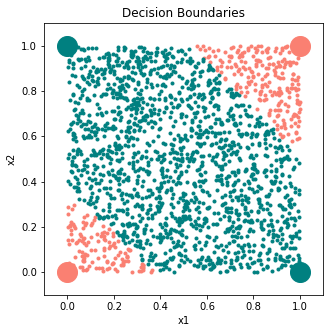

NN training succeeded!


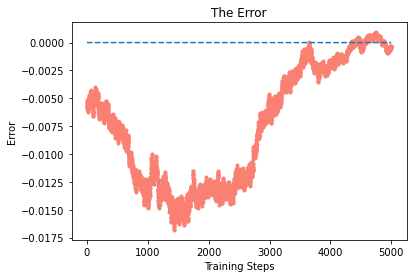

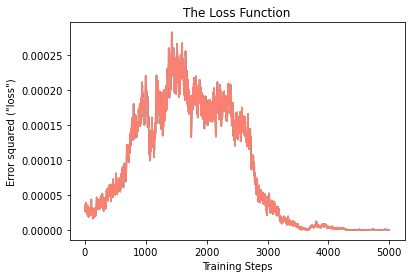

In [20]:
'''
Part 1 Training XOR Architecture: [2, 2, 1], Activation: sigmoid
'''


nn = NeuralNetwork([2, 2, 1], activation='sigmoid')
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([0, 1, 1, 0])
nn.fit(X, y, learning_rate=0.6, steps=10000, tol=1e-1)


### Part 2

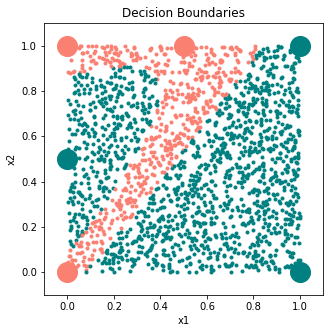

NN training succeeded!


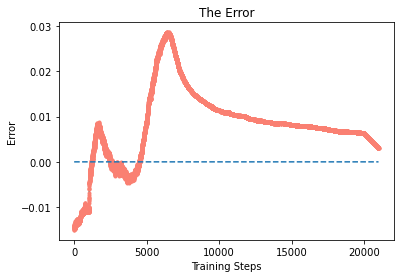

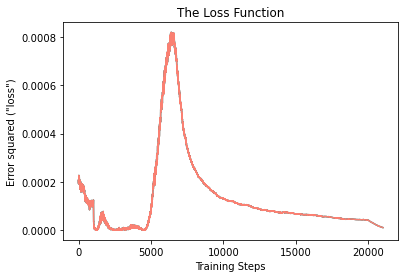

In [5]:
'''
Part 2 Architecture: [2, 2, 2, 1], Activation: tanh
'''
nn = NeuralNetwork([2, 2, 2, 1], activation='tanh')
X = np.array([[0, 0],
              [0, 1],
              [0.5, 1],
              [0, 0.5],
              [1, 0],
              [1, 1]])
y = np.array([0, 0, 0, 1, 1, 1])
nn.fit(X, y, steps=30000, tol=1e-2)

###  Hardcode Class for XOR [2,  2,  1]

In [5]:
'''Hardcode Class'''

class NeuralNetwork_Hardcode:
    '''
    XOR [2, 2, 1] architecture:
    This class uses the XOR gate truth table as the training set for the 2-layers-3-neurons network.

    Methods:
       __init__(layers, activation=‘sigmoid’)): set initial layers and activation function
       fit(X, y, learning_rate, steps, tol): process training using X data and labels Y
       find_RMS_error(X, y): find the RMS error for all the training data X
       predict(x): make predictions to group training data x into 0 or 1
       visual_NN_boundaries(Nsamp=2000): visualize the boundaries using 2000 testing points
    '''

    def __init__(self, layers, activation='sigmoid'):
        '''
        This instantiation function initializes constructors for the Neural Network class' objects

        Args:
            layers (list): The number of layers
            activation (str): The type of activation function with sigmoid as the default
        '''
        self.layers = layers
        self.weights = []
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_prime
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_prime

    def fit(self, X, y, learning_rate=0.2, steps=100000, tol=1e-2):
        '''
        Processes training using X data and labels Y

        Args:
            X (numpy.ndarray): the training data
            y (numpy.ndarray): labels
            learning_rate (float): alpha, default 0.2
            steps (int): number of training steps, default 100000
            tol (float): number of tolerance, default 0.01
        '''
        a02 = np.array([1]) # bias
        # Create initial weights
        L = len(self.layers) - 1
        i = self.layers[0] + 1
        j = self.layers[0 + 1] + 1
        w0 = np.random.rand(i, j)
        self.weights.append(w0)
        w1 = np.random.rand(j)
        self.weights.append(w1)

        # Forward Propagation: Layer 0
        X = np.insert(X, 2, a02, axis=1)
        errors = []

        for step in range(steps):
            index = np.random.choice(len(X))
            a0 = X[index]
            a1 = sigmoid(np.dot(a0, w0))
            a2 = sigmoid(np.dot(a1, w1))

            # Calculate errors
            error = y[index] - a2
            errors.append(error)
            window_size = 32
            smooth_errors = np.convolve(errors, np.ones((window_size,)) / window_size, mode='same')

            # Backward propagation: Layer 1
            delta1 = error * sigmoid_prime(a2)
            self.weights[1] += delta1 * a1 * learning_rate

            # Backward propagation: Layer 0
            delta0 = np.atleast_2d(delta1 * w1 * sigmoid_prime(a1))
            a0 = np.atleast_2d(a0)
            self.weights[0] += np.dot(a0.T, delta0) * learning_rate
            
            # Report Training Progress
            if step % (steps/10) == 0:
                print('Step: ', step)
                print('Training Results(data, prediction, expected):')
                for i in range(len(X)):
                    x = X[i]
                    print('{}, {}, {}'.format(x[:-1], self.predict(x), y[i]))
                
                # Calculate RMS
                rms = self.find_RMS_error(X, y)
                print('RMS_err: {:.5f}\n'.format(rms))
                if rms < tol:
                    print('NN training succeeded!')
                    break
        if rms > tol:
            print('NN training failed.')

        # Plot boundaries
        self.visual_NN_boundaries()

        # Plot error
        self.plot_error(smooth_errors)

    def find_RMS_error(self, X, y):
        '''
        Finds the “average error” for all the training data X
        Args:
            X (numpy.ndarray): each entry of x
            y (numpy.ndarray): labels
        Returns:
            RMS_err: Root Mean Square Error
        '''
        rms_total = 0
        predicted_output = self.predict(X)
        for i in range(len(y)):
            rms_total += (y[i] - predicted_output[i]) ** 2
        rms_err = np.sqrt(rms_total/len(y))
        return rms_err
    
    def plot_error(self, error):
        '''
        Plot error
        Args:
            Error (np.array): smooth errors
        '''
        plt.figure()
        plt.plot(error, color='teal')
        plt.plot(error, '.', color='salmon')
        plt.plot(np.zeros(len(error)), '--')
        plt.ylabel('Error')
        plt.xlabel('Training Steps')
        plt.title('The Error')
        plt.show()

        plt.figure()
        plt.plot(np.array(error) ** 2, color='teal')
        plt.plot(np.array(error) ** 2, color='salmon')
        plt.ylabel('Error squared ("loss")')
        plt.xlabel('Training Steps')
        plt.title('The Loss Function')
        plt.show()

    def predict(self, x):
        '''
        Make predictions to training data x into 0 or 1

        Args:
            x (numpy.ndarray): the training data
        Returns:
            prediction : Classification y values red or blue
        '''
        for w in range(len(self.weights)):
            x = self.activation(np.dot(x, self.weights[w]))

        return x

    def visual_NN_boundaries(self, Nsamp=2000):
        '''
        Visualizes boundaries after the training is done
        Args:
            Nsamp (int): number of samples, default 2000
        '''
        x_arr = np.random.rand(Nsamp, 2)
        x_arr = np.atleast_2d(np.insert(x_arr, 2, 1, axis=1))
        z_arr = np.array([])

        for x in x_arr:
            z = self.predict(x)
            z_arr = np.append(z_arr, z)

        threshold = 0.5
        plt.figure()
        for i, x in enumerate(x_arr):
            if z_arr[i] <= threshold:
                plt.plot(x[0], x[1], '.', color='teal')
            else:
                plt.plot(x[0], x[1], '.', color='salmon')

        # Training Set
        plt.plot([1, 0], [1, 0], 'o', color='teal', ms=10)
        plt.plot([0, 1], [1, 0], 'o', color='salmon', ms=10)
        plt.title('Decision Boundaries')
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.show()

Step:  0
Training Results(data, prediction, expected):
[0 0], 0.7927920121559302, 0
[0 1], 0.8246603402226621, 1
[1 0], 0.8189142146493141, 1
[1 1], 0.8408020039749424, 0
RMS_err: 0.59140

Step:  5000
Training Results(data, prediction, expected):
[0 0], 0.4218423769179388, 0
[0 1], 0.44546200766592703, 1
[1 0], 0.5215359361802971, 1
[1 1], 0.47892476218848024, 0
RMS_err: 0.48574

Step:  10000
Training Results(data, prediction, expected):
[0 0], 0.08959950933748825, 0
[0 1], 0.7820151907402657, 1
[1 0], 0.7845916467828452, 1
[1 1], 0.23320081726750053, 0
RMS_err: 0.19769

Step:  15000
Training Results(data, prediction, expected):
[0 0], 0.04038399639740795, 0
[0 1], 0.897236758341693, 1
[1 0], 0.9023980659358467, 1
[1 1], 0.12719501239338601, 0
RMS_err: 0.09733

NN training succeeded!


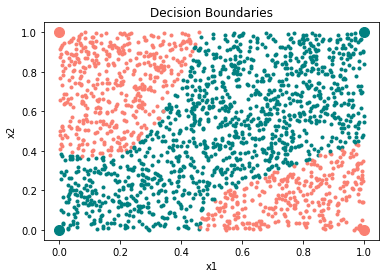

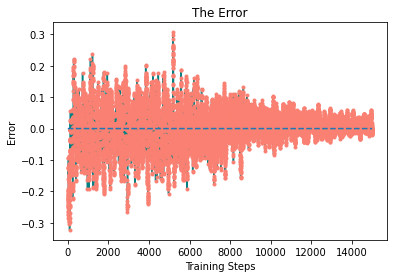

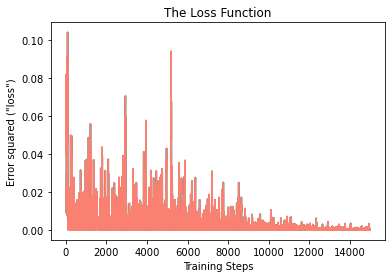

In [6]:
'''
Hardcode XOR NN class
'''
def main():
    nn = NeuralNetwork_Hardcode([2, 2, 1], activation='sigmoid')
    X = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
    y = np.array([0, 1, 1, 0])

    # Test fit
    nn.fit(X, y, learning_rate=0.2, steps=50000, tol=1e-1)
main()

<Figure size 432x288 with 0 Axes>

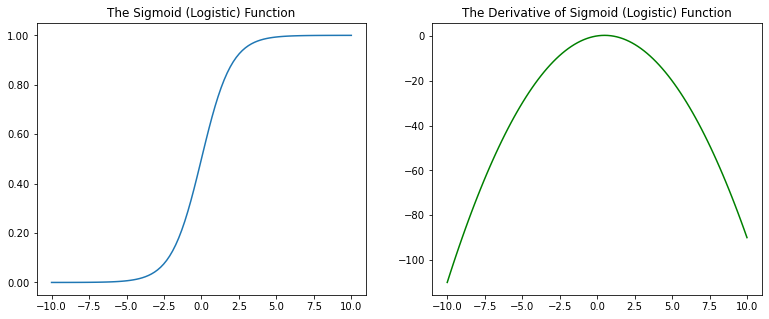

<Figure size 432x288 with 0 Axes>

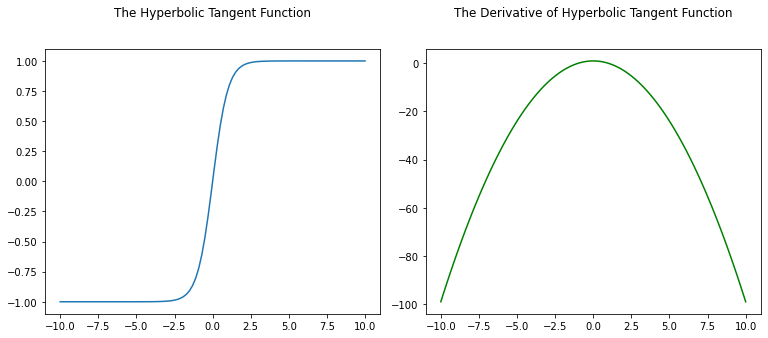

In [19]:
'''
Activation Functions Tester
'''
x = np.linspace(-10, 10, 100)

# Test sigmoid and sigmoid_prime
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
ax[0].plot(x, sigmoid(x),)
ax[0].set_title('The Sigmoid (Logistic) Function')
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].plot(x, sigmoid_prime(x), 'g')
ax[1].set_title('The Derivative of Sigmoid (Logistic) Function')
plt.show()

# Test tanh and tanh_prime
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10.8, 4.8))
ax[0].plot(x, tanh(x))
ax[0].set_title('The Hyperbolic Tangent Function', loc='center', y=1.1)
ax[1].plot(x, tanh_prime(x), 'g')
ax[1].set_title('The Derivative of Hyperbolic Tangent Function', loc='center', y=1.1)
fig.tight_layout()
plt.show()